In [77]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/eddie/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample', 'float64', 'copy', 'cross']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [78]:
# Import common libraries.
from __future__ import division
from solvers import *
from utils import *
import ising_eqn_5_sym

# Define common functions.
calc_e,calc_observables,mchApproximation = define_ising_mch_helpers()

# Generate example data set.
n = 5
h,J = np.random.normal(scale=.1,size=n),np.random.normal(scale=.1,size=n*(n-1)//2)
hJ = np.concatenate((h,J))
p = ising_eqn_5_sym.get_probs(hJ)
sisjTrue = ising_eqn_5_sym.get_stats(hJ)

allstates = bin_states(n,True)
sample = allstates[random.choice(range(2**n),size=5000,replace=True,p=p)]
sisj = pair_corr(sample,concat=True)

In [83]:
pickle.dump({'sample':sample,'hJ':hJ,'sisj':sisj},open('temp.p','wb'),-1)

# Exact example.

In [ ]:
# Define function specific to Exact class.
def calc_observables_multipliers(J):
    """
    Calculate observables from probability distribution given Langrangian multipliers.
    """
    E = calc_e(allstates,J)
    return pair_corr( allstates, np.exp(-E-logsumexp(E)),concat=True )

# Declare and call solver.
solver = Exact(n,
               calc_observables_multipliers=calc_observables_multipliers,
               calc_observables=calc_observables)
estMultipliers,soln = solver.solve(constraints=sisjTrue,fsolve_kwargs={'method':'powell'})

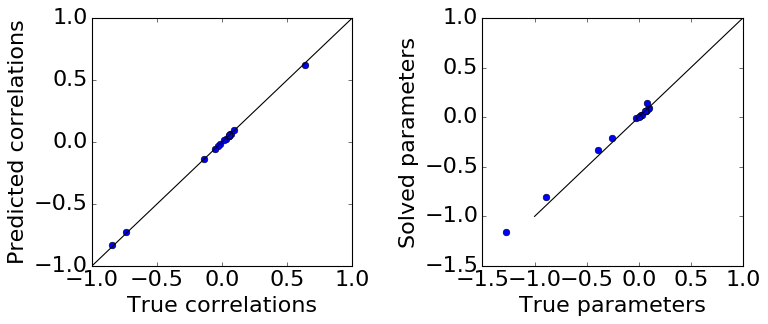

In [63]:
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisjTrue,ising_eqn_5_sym.get_stats(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,soln['x'],'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

## MCH example.

In [75]:
# Declare and call solver.
solver = MCH(n,calc_e=calc_e,calc_observables=calc_observables,
             sample_size=100,sample_method='metropolis',mch_approximation=mchApproximation)
soln = solver.solve(sisj,maxiter=10)
soln = solver.solve(sisj,initial_guess=soln,maxiter=10,
                    learn_params_kwargs={'maxdlamda':.1,'eta':.1})
soln = solver.solve(sisj,initial_guess=soln,maxiter=20,
                    learn_params_kwargs={'maxdlamda':.05,'eta':.05})

TypeError: __init__() got an unexpected keyword argument 'calc_e'

TypeError: unhashable type

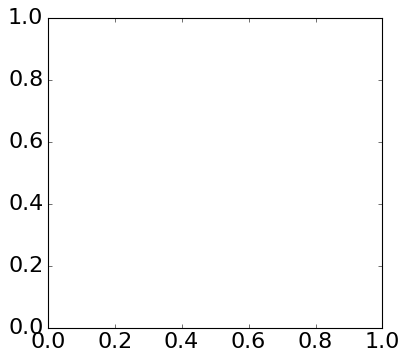

In [76]:
import ising_eqn_5_sym

fig,ax = plt.subplots(figsize=(5.4,5))
ax.plot(sisj,ising_eqn_5_sym.get_stats(soln),'o')
ax.plot([-1,1],[-1,1],'k-')
ax.set(xlabel='True correlations',ylabel='Predicted correlations')

## MPF example.

In [79]:
# Declare and call solver.
solver = MPF(n,calc_observables=calc_observables)
estMultipliers,soln = solver.solve(sample)

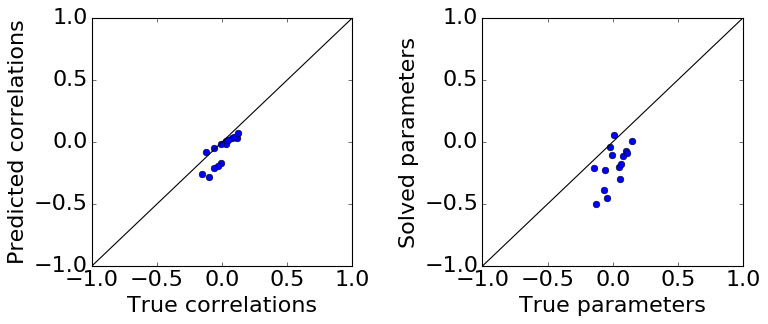

In [81]:
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.get_stats(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,soln['x'],'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Pseudolikelihood

In [15]:
from solvers import *
from utils import *

calc_e,_ = define_ising_mch_helpers()

In [16]:
# Generate example data set.
n = 5
allstates = bin_states(n,True)
def calc_observables(J):
    E = calc_e(allstates,J)
    return pair_corr( allstates, exp(-E-logsumexp(E)),concat=True )

multipliers = random.normal(scale=.5,size=n*(n-1)//2+n)
p = ising_eqn_5_sym.get_probs(multipliers)

sisj = pair_corr(allstates,p,concat=True)

In [17]:
samples = allstates[random.choice(range(2**n),size=1000,p=p)]

In [18]:
solver = Pseudo(n,calc_e=calc_e,calc_observables=calc_observables)

In [19]:
solver.solve(samples)

Minimizing for r = 0
Optimization terminated successfully.
         Current function value: 116.244905
         Iterations: 29
         Function evaluations: 43
         Gradient evaluations: 71
         Hessian evaluations: 29
Minimizing for r = 1
Optimization terminated successfully.
         Current function value: 149.319181
         Iterations: 51
         Function evaluations: 72
         Gradient evaluations: 122
         Hessian evaluations: 51
Minimizing for r = 2
Optimization terminated successfully.
         Current function value: 349.765418
         Iterations: 135
         Function evaluations: 168
         Gradient evaluations: 302
         Hessian evaluations: 135
Minimizing for r = 3
Optimization terminated successfully.
         Current function value: 149.726771
         Iterations: 149
         Function evaluations: 181
         Gradient evaluations: 329
         Hessian evaluations: 149
Minimizing for r = 4
Optimization terminated successfully.
         Current fun

array([-0.02889561, -0.85069858,  0.00202065,  0.79219604, -0.14393361,
       -1.2856426 , -0.23464257,  0.91978623, -0.01715534,  0.40723644,
        0.63976354, -0.40764913, -0.56333554,  0.04610493,  0.97079228])

[<matplotlib.text.Text at 0x1184c9b50>, <matplotlib.text.Text at 0x1183d71d0>]

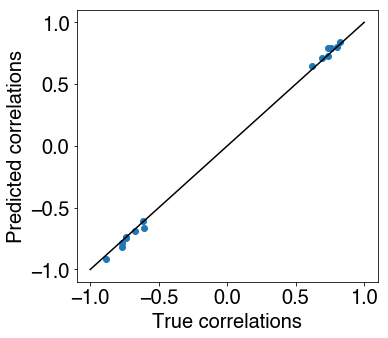

In [20]:
import ising_eqn_5_sym

fig,ax = plt.subplots(figsize=(5.4,5))
ax.plot(sisj,ising_eqn_5_sym.get_stats(solver.multipliers),'o')
ax.plot([-1,1],[-1,1],'k-')
ax.set(xlabel='True correlations',ylabel='Predicted correlations')

# Adaptive cluster expansion

In [21]:
from solvers import *
from utils import *

#calc_e,_ = define_ising_mch_helpers()

In [22]:
# Generate example data set.
n = 5
allstates = bin_states(n,True)
def calc_observables(J):
    E = calc_e(allstates,J)
    return pair_corr( allstates, exp(-E-logsumexp(E)),concat=True )

multipliers = random.normal(scale=.5,size=n*(n-1)//2+n)
p = ising_eqn_5_sym.get_probs(multipliers)

sisj = pair_corr(allstates,p,concat=True)

In [23]:
samples = allstates[random.choice(range(2**n),size=1000,p=p)]

In [24]:
solver = ClusterExpansion(n,calc_e=calc_e,calc_observables=calc_observables)

In [25]:
threshold = 0.001
solver.solve(samples,threshold)

adaptiveClusterExpansion: Clusters of size 2
adaptiveClusterExpansion: Clusters of size 3
adaptiveClusterExpansion: Clusters of size 4
adaptiveClusterExpansion: Clusters of size 5
adaptiveClusterExpansion: Clusters of size 6


array([-0.14343198,  0.26126645, -1.13508147, -0.49189368,  0.60953674,
        1.21685379, -0.35028344, -0.3388927 , -0.67790483, -0.20598558,
        0.62539789, -0.68202705, -0.70137302,  0.19364541,  0.67776595])

[<matplotlib.text.Text at 0x1186400d0>, <matplotlib.text.Text at 0x1184dd250>]

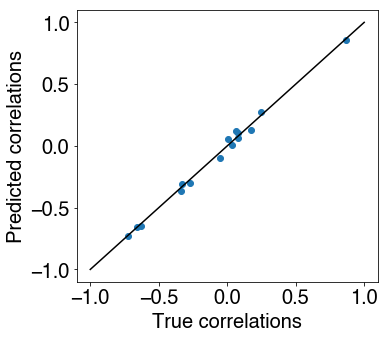

In [26]:
import ising_eqn_5_sym

fig,ax = plt.subplots(figsize=(5.4,5))
ax.plot(sisj,ising_eqn_5_sym.get_stats(solver.multipliers),'o')
ax.plot([-1,1],[-1,1],'k-')
ax.set(xlabel='True correlations',ylabel='Predicted correlations')